# Recurrent Neural Network - Predict Stock Market with Finance Data and News Data
The source of inspiration was this blog post: 
https://medium.com/@dmytrosazonov/how-to-predict-stock-market-using-google-tensorflow-and-lstm-neural-network-81ccc41a22a8

This is the basis for training the neural network. 

# Import necesary libraries

In [15]:
import os

import numpy as np
from numpy import array
from numpy import hstack

from math import sqrt

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from pandas import DataFrame
from pandas import concat

# AI
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import backend as keras_backend
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import datetime

# Graphics library
import matplotlib.pyplot as plt

# Set random seed for reproducibility
from numpy.random import seed
seed(42)
rng = np.random.RandomState(42)

import tensorflow
tensorflow.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Settings

In [16]:
# Set the parametes need for the RNN

# Stock ticker, TSLA. Here we will get the stick ticker the others too.
STOCK = 'TSLA'

# Load Data

In [17]:
import duckdb
import os

class PredictionInputRepository:
    def __init__(self, csv_file_path=None):
        self.connection = duckdb.connect(database=':memory:', read_only=False)
        if os.path.isfile(f'{csv_file_path}/prediction_input.csv'):
            try:
                self.connection.execute(f"IMPORT DATABASE '{csv_file_path}';")
            except Exception as e:
                self._create_table()
                self.connection.execute(f"EXPORT DATABASE '{csv_file_path}';")
        else:
            self._create_table()

    def _create_table(self):
        self.connection.execute("CREATE TABLE prediction_input (id VARCHAR UNIQUE, articleId INTEGER UNIQUE, timestamp VARCHAR, close DOUBLE, relevance DOUBLE, sentimentPositive DOUBLE, sentimentNegative DOUBLE, sentimentNeutral DOUBLE)")
        self.connection.execute("CREATE SEQUENCE id_sequence START 1 INCREMENT BY 1;")

    def insert(self, prediction_input):
        self.connection.execute("PREPARE insert_prediction_input AS "
                                "INSERT INTO prediction_input VALUES (nextval('id_sequence'), ?, ?, ?, ?, ?, ?, ?) ON CONFLICT DO NOTHING;")
        self.connection.execute(f"EXECUTE insert_prediction_input('{prediction_input['articleId']}', '{prediction_input['timestamp']}', {prediction_input['close']}, {prediction_input['relevance']}, {prediction_input['sentimentPositive']}, {prediction_input['sentimentNegative']}, {prediction_input['sentimentNeutral']});")

    def select_all(self):
        return self.connection.execute("SELECT * FROM prediction_input").fetchdf()

    def select_by_date(self, date_from, date_to):
        return self.connection.execute(f"SELECT * FROM prediction_input WHERE strptime(timestamp, '%Y-%m-%dT%H:%M:%S%z') BETWEEN strptime('{date_from}','%Y-%m-%d') AND strptime('{date_to}','%Y-%m-%d')").fetchdf()
    
    def select_by_date_order(self, date_format = '%Y-%m-%dT%H:%M:%S%z'):
        return self.connection.execute(f"SELECT * FROM prediction_input ORDER BY strptime(timestamp, '{date_format}') DESC").fetchdf()

    def export(self, csv_file):
        self.connection.execute(f"EXPORT DATABASE '{csv_file}';")


# Prepare Prediction Input

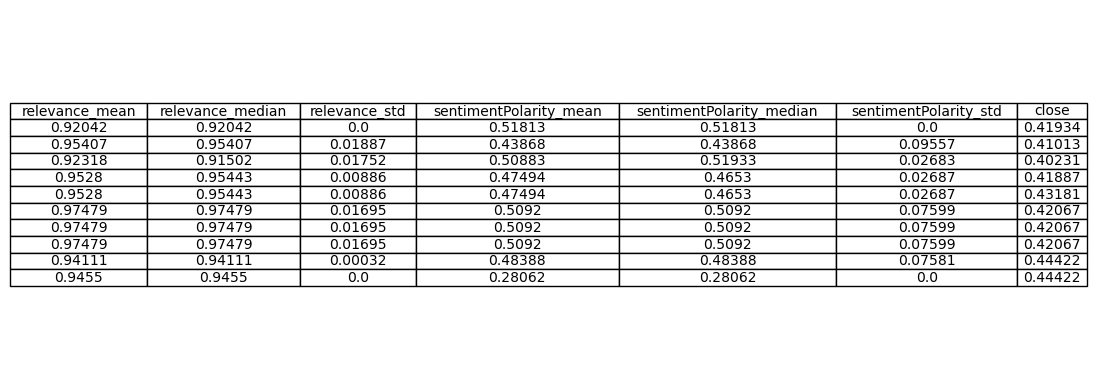

In [18]:
def prepare_prediction_input(source):
    prediction_input_repo = PredictionInputRepository(f"prediction_input/{source}")

    if source == "bbc":
        return prediction_input_repo.select_by_date_order("%Y-%m-%dT%H:%M:%S.%fZ")
    else:
        return prediction_input_repo.select_by_date_order()

# input as df
def show_prediction_input_table(prediction_input):
    most_ten_input_data = prediction_input.tail(10)
    fig, ax = plt.subplots(1, 1)
    ax.axis('off')
    table = plt.table(cellText=most_ten_input_data.values, colLabels=most_ten_input_data.columns, cellLoc = 'center', loc='center')
    table.auto_set_column_width(col=list(range(len(most_ten_input_data.columns))))
    plt.show()
    
def plot_graph(input_df, column_name):
    plt.figure(figsize=(16,10))
    plt.plot(input_df[column_name])
    plt.xlabel("days")
    plt.ylabel("price")
    plt.legend([f'{column_name} for {STOCK}'])
    plt.show()

def calculate_sentiment_polarity(rows):
    rows["sentimentPolarity"] = round(rows['sentimentPositive'] - rows['sentimentNegative'],5)
    rows["sentimentPolarity"] = np.interp(rows["sentimentPolarity"], (-1, 1), (0, 1)) if rows["relevance"] > 0 else 0
    rows = rows.drop(['sentimentPositive', 'sentimentNegative', 'sentimentNeutral'])
    return rows

def calculate_statistics_per_day(input):
    input["timestamp"] = input["timestamp"].apply(lambda x: x.split("T")[0])
    input_temp = input.drop(input[input.relevance <= 0].index)
    input_temp = input_temp.groupby(["timestamp"], as_index=False).agg({"relevance": ["mean", "median", "std"], "sentimentPolarity": ["mean", "median", "std"]})
    
    input_temp.columns = [("_".join(x) if x[1] != "" else x[0]) for x in input_temp.columns.ravel()]

    return input_temp

def forward_fill_missing_dates_values(input_df):
    input_df["timestamp"] = pd.to_datetime(input_df["timestamp"])
    input_df = input_df.set_index("timestamp")
    input_df = input_df.resample("D").ffill().reset_index()
    return input_df

def add_close_price_per_date(input_df):    
    min_date = str(input_df["timestamp"].min()).split(" ")[0]
    max_date = str(input_df["timestamp"].max()).split(" ")[0]
    
    stock_df = yf.get_data(
        STOCK,
        start_date=min_date,
        end_date=max_date,
        interval='1d')
    stock_df = stock_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
    stock_df['date'] = stock_df.index
    
    input_df = pd.merge(input_df, stock_df, left_on="timestamp", right_on="date", how="left").drop("date", axis=1)
    
    return input_df

def fill_missing_close_price_values(input_df):
    input_df["close"] = input_df["close"].ffill().bfill()
    return input_df

def fill_missing_standard_deviation(input_df):
    input_df["relevance_std"] = input_df["relevance_std"].fillna(0)
    input_df["sentimentPolarity_std"] = input_df["sentimentPolarity_std"].fillna(0)
    return input_df

def round_values(input_df):
    input_df = input_df.round(5)
    return input_df

def transform_close_price_min_max(input_df):
    input_df["close"] = input_df["close"].apply(lambda x: np.interp(x, (input_df["close"].min(), input_df["close"].max()), (0, 1)))
    return input_df

def shift_closing_price(input_df, shift):
    input_df["close"] = input_df["close"].shift(-shift)
    return input_df

def get_future(input_df, future_days = 1):
    input_df["future"] = input_df["close"].shift(future_days)
    return input_df

def get_processed_dataframe_prediction_input(source, exclude_col = []):
    input_df = prepare_prediction_input(source).drop("close", axis=1)
    input_df = input_df.apply(calculate_sentiment_polarity, axis=1)
    input_df = calculate_statistics_per_day(input_df)
    input_df = forward_fill_missing_dates_values(input_df)
    input_df = add_close_price_per_date(input_df)

    min_close = input_df["close"].min()
    max_close = input_df["close"].max()

    input_df = fill_missing_close_price_values(input_df)
    input_df = fill_missing_standard_deviation(input_df)
    input_df = transform_close_price_min_max(input_df)
    input_df = round_values(input_df)
    input_df = fill_missing_close_price_values(input_df)
    # input_df = shift_closing_price(input_df, 1)
    # input_df = get_future(input_df, future_days)

    #future_date = input_df["timestamp"].max() + pd.Timedelta(days=1)
    #new_row = pd.DataFrame({"timestamp": [future_date]})
    #input_df = pd.concat([input_df, new_row], ignore_index=True)

    input_df.set_index("timestamp", inplace=True)

    return input_df, (min_close, max_close)

test_df, (_, _) = get_processed_dataframe_prediction_input("ft")
show_prediction_input_table(test_df)

# Transform multivariate time series to supervised learning input

This part relies on this blog post: 
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [32]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.ffill()
        
    return agg

def prepare_multivariate_input_data(input_df):
    # load dataset

    dataset = input_df.copy()
    values = dataset.values
    # frame as supervised learning
    reframed = series_to_supervised(values, 1, 6)
    # drop columns we don't want to predict
    
    return reframed

def prepare_multivariate_generator_input_data(input_df):    
    in_seq_list = []
    
    for i in range(len(input_df.columns)):
        values = input_df.iloc[:, i].values
        values = values.reshape((len(values), 1))
        in_seq_list.append(values)
        
    dataset = hstack(tuple(in_seq_list))

    n_features = dataset.shape[1]
    n_input = 2
    
    generator = TimeseriesGenerator(dataset, dataset, length=n_input, batch_size=8)
    
    return generator, n_features

generator_mv_input_df = prepare_multivariate_generator_input_data(test_df.tail(10))


Index(['relevance_mean', 'relevance_median', 'relevance_std',
       'sentimentPolarity_mean', 'sentimentPolarity_median',
       'sentimentPolarity_std', 'close'],
      dtype='object')
[[9.2042e-01 9.2042e-01 0.0000e+00 5.1813e-01 5.1813e-01 0.0000e+00
  4.1934e-01]
 [9.5407e-01 9.5407e-01 1.8870e-02 4.3868e-01 4.3868e-01 9.5570e-02
  4.1013e-01]
 [9.2318e-01 9.1502e-01 1.7520e-02 5.0883e-01 5.1933e-01 2.6830e-02
  4.0231e-01]
 [9.5280e-01 9.5443e-01 8.8600e-03 4.7494e-01 4.6530e-01 2.6870e-02
  4.1887e-01]
 [9.5280e-01 9.5443e-01 8.8600e-03 4.7494e-01 4.6530e-01 2.6870e-02
  4.3181e-01]
 [9.7479e-01 9.7479e-01 1.6950e-02 5.0920e-01 5.0920e-01 7.5990e-02
  4.2067e-01]
 [9.7479e-01 9.7479e-01 1.6950e-02 5.0920e-01 5.0920e-01 7.5990e-02
  4.2067e-01]
 [9.7479e-01 9.7479e-01 1.6950e-02 5.0920e-01 5.0920e-01 7.5990e-02
  4.2067e-01]
 [9.4111e-01 9.4111e-01 3.2000e-04 4.8388e-01 4.8388e-01 7.5810e-02
  4.4422e-01]
 [9.4550e-01 9.4550e-01 0.0000e+00 2.8062e-01 2.8062e-01 0.0000e+00
  4.442

# Split the data into training and test data

In [9]:
def get_train_test_data(df):
    split_ratio = 0.80
    
    split_index = int(len(df) * split_ratio)

    train_df = df[:split_index]
    test_df = df[split_index:]

    # Split into input features (X) and target variable (y)
    train_x, train_y = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
    test_x, test_y = test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values

    # Reshape input to be 3D [samples, timesteps, features]
    train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
    test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

    return train_x, train_y, test_x, test_y

# Create the two-layer LSTM model

In [10]:
def create_model(train_x):
    model_seq = Sequential()
    model_seq.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
    model_seq.add(Dense(1))
    model_seq.compile(loss='mae', optimizer='adam')
    return model_seq 

def fit_model(model_seq, train_x, train_y, test_x, test_y):
    batch_size = 94
    epochs = 100
    
    # fit network
    history = model_seq.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), verbose=1, shuffle=False)
    return history

def plot_history(fit_res):
    # plot history
    plt.plot(fit_res.history['loss'], label='training loss')
    plt.plot(fit_res.history['val_loss'], label='validation loss')
    plt.legend()
    plt.show()


In [11]:
def get_prediction(model, test_x):
    # make a prediction
    yhat = model.predict(test_x)
    test_x_new = test_x.reshape((test_x.shape[0], test_x.shape[2]))
    
    # Concatenate the predicted values (yhat) with the other features from test_X
    inv_yhat = np.concatenate((yhat, test_x_new[:, 1:]), axis=1)
    
    # Extract the predicted "close" values
    # for i in range(1, inv_yhat.shape[1]):
    predicted_close = inv_yhat[:, 6]
    #predicted_future_close = inv_yhat[:, 7]
    
    plt.figure(figsize=(16,10))
    plt.plot(predicted_close, label='Predicted - Close')
    #plt.plot(predicted_future_close[:100], label='Predicted - Future')
    
    plt.xlabel("days")
    plt.ylabel("price")
    plt.legend(bbox_to_anchor =(1, 1), fontsize=15)
    plt.show()
    
    #print(inv_yhat)
    #return []
    return predicted_close #, predicted_future_close

def plot_prediction_result(predicted_close, train_y, test_y, min_close, max_close):
    test_Y_test = np.append(train_y, test_y)
    predicted_close_test = np.append(train_y, predicted_close)
    
    plt.figure(figsize=(16,10))
    plt.plot(test_Y_test, label='Test - Close')
    plt.plot(predicted_close_test, label='Predicted - Close')
    plt.plot(train_y, label='Train')

    plt.xlabel("days")
    plt.ylabel("price")
    plt.legend(bbox_to_anchor =(1, 1), fontsize=15)
    plt.show()

    rmse = sqrt(mean_squared_error(predicted_close, test_y))
    print('Test RMSE: %.3f ' % rmse)

def run_fit_predict_pipeline(source, exclude_col = [], future_days = 7):
    keras_backend.clear_session()
    predictions = []

    input_df, (min_close, max_close) = get_processed_dataframe_prediction_input(source, exclude_col)
    mv_input_df = prepare_multivariate_input_data(input_df)
    
    train_X, train_Y, test_X, test_Y = get_train_test_data(mv_input_df)
    model = create_model(train_X)

    fit_result = fit_model(model, train_X, train_Y, test_X, test_Y)
    plot_history(fit_result)
    
    predicted_close = get_prediction(model, test_X)

    prediction_df = pd.DataFrame({
        "date": input_df.tail(predicted_close.shape[0]).index.tolist(),
        "predicted_close": np.interp(predicted_close, (0, 1), (min_close, max_close))
    })
    prediction_df.set_index("date", inplace=True)    

    # future_X = mv_input_df.iloc[-future_days:, :-1].values
    # future_X = future_X.reshape((future_X.shape[0], 1, future_X.shape[1]))
    # future_predictions = model.predict(future_X)
    # 
    # future_predictions = future_predictions.flatten()
    # future_predictions = np.interp(future_predictions, (0, 1), (min_close, max_close))
    # 
    # # Generate future dates
    # last_date = input_df.index.max()
    # future_dates = pd.date_range(start=last_date, periods=future_days + 1, inclusive='right')
    # 
    # # Create a DataFrame with future dates and predictions
    # future_df = pd.DataFrame({'date': future_dates, 'predicted_close': future_predictions})

    future_predictions = np.interp(predicted_close, (0, 1), (min_close, max_close))
    # print("Predicted close: ", future_predictions[-1])
    #print(test_X)
    #print("Test X len: ", len(test_X), "Predicted close len: ", len(predicted_close))

    stock_df = yf.get_data(
        STOCK,
        start_date=prediction_df.index[0].strftime("%Y-%m-%d"),
        end_date=prediction_df.tail(1).index[0].strftime("%Y-%m-%d"),
        interval='1d')
    
    stock_df = stock_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
    stock_df.reset_index()
    stock_df["close"] = stock_df["close"].ffill().bfill()

    print(prediction_df.tail(10))
    print(stock_df.tail(10))

    plt.figure(figsize=(16,10))
    plt.plot(stock_df.tail(100), label='Actual - Close')
    plt.plot(prediction_df.tail(100), label='Predicted - Close')

    plt.xlabel("days")
    plt.ylabel("price")
    plt.legend(bbox_to_anchor =(1, 1), fontsize=15)
    plt.show()
    
        


Epoch 1/100


/Users/sebastiantatar/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: nan - val_loss: nan
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: nan - val_loss: nan
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: n

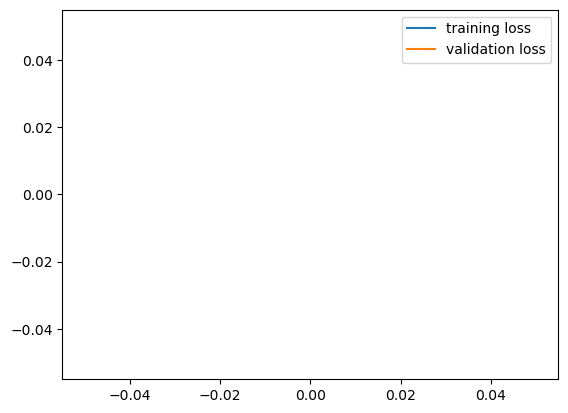

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


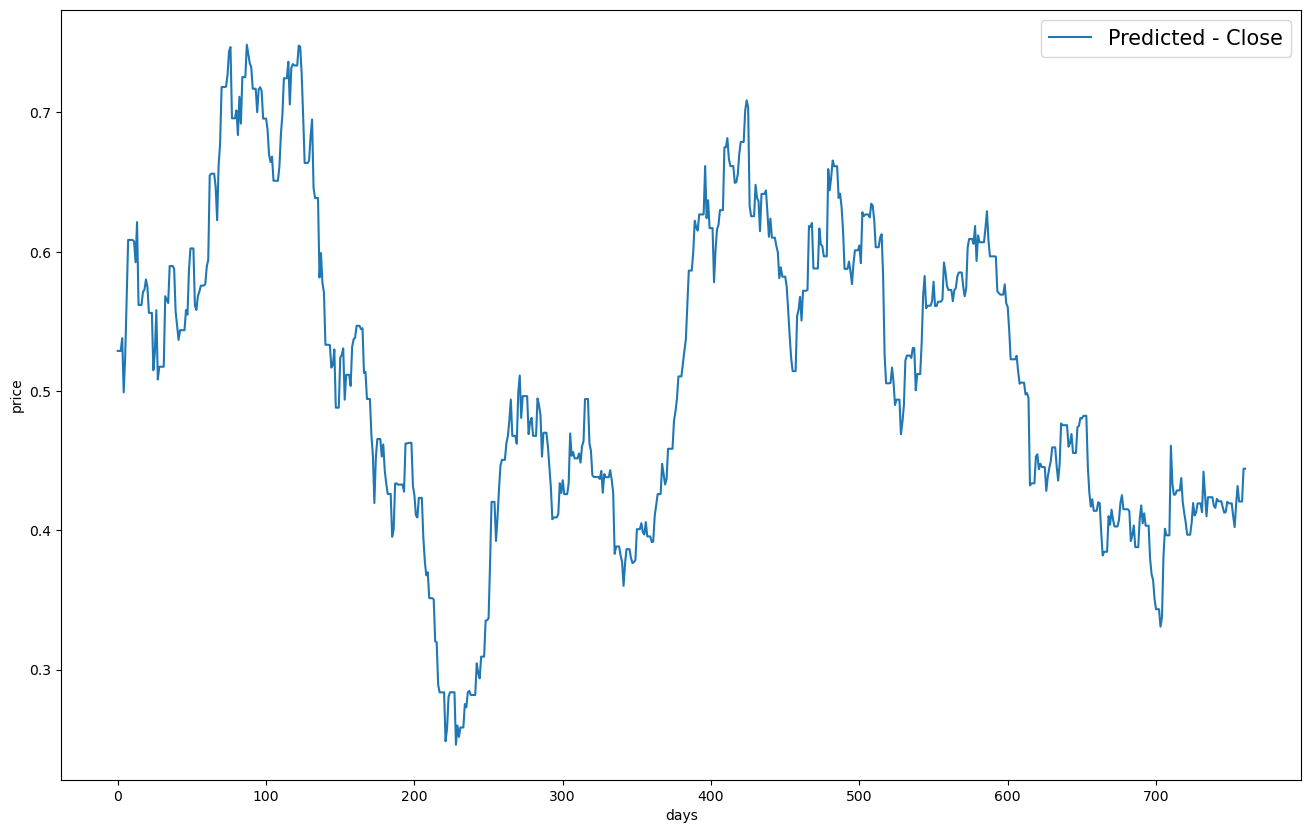

            predicted_close
date                       
2024-06-10       173.790772
2024-06-11       170.659706
2024-06-12       177.290198
2024-06-13       182.471270
2024-06-14       178.010903
2024-06-15       178.010903
2024-06-16       178.010903
2024-06-17       187.440135
2024-06-18       187.440135
2024-06-19              NaN
                 close
2024-06-05  175.000000
2024-06-06  177.940002
2024-06-07  177.479996
2024-06-10  173.789993
2024-06-11  170.660004
2024-06-12  177.289993
2024-06-13  182.470001
2024-06-14  178.009995
2024-06-17  187.440002
2024-06-18  184.860001


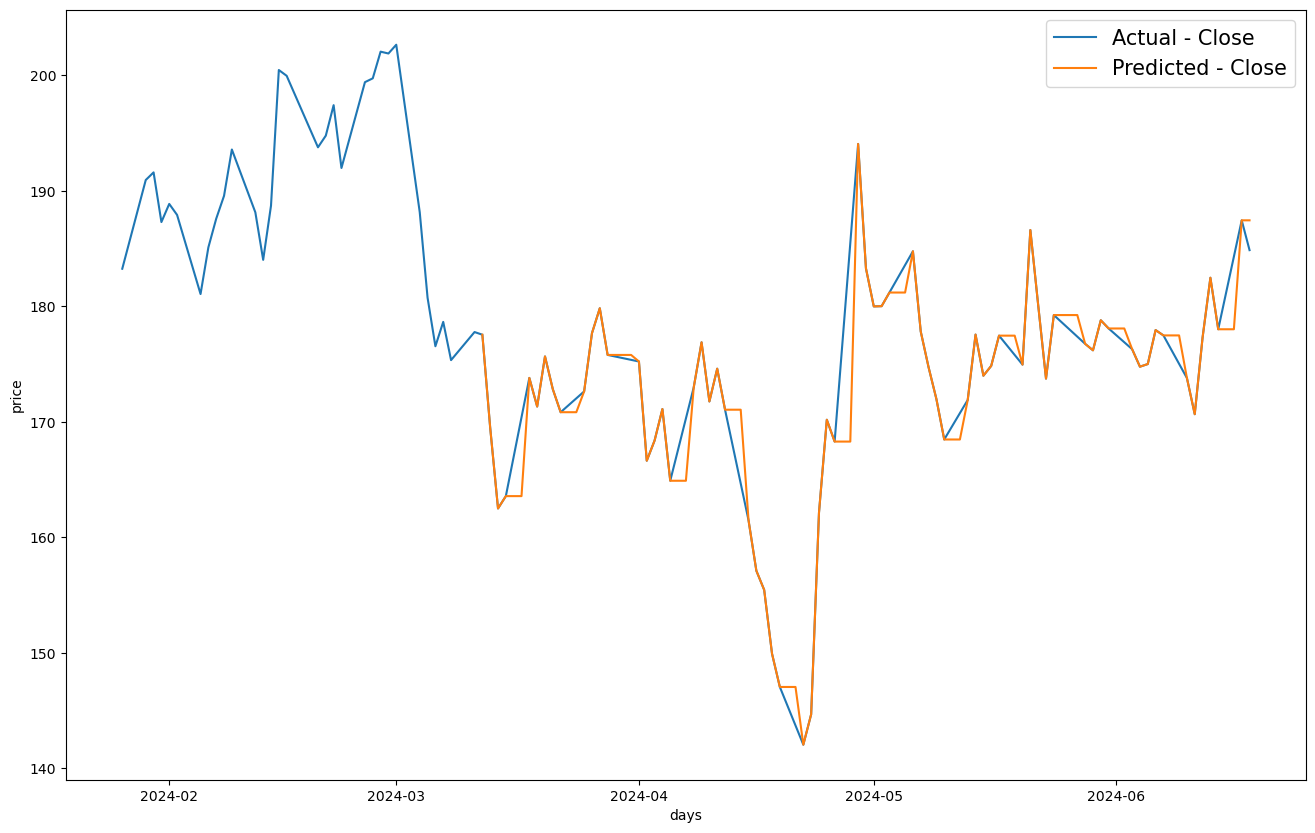

In [12]:
# run_fit_predict_pipeline("ft", ["relevance_mean", "relevance_median", "relevance_std", "sentimentPolarity_mean", "sentimentPolarity_median", "sentimentPolarity_std"])

# run_fit_predict_pipeline("ft", ["sentimentPolarity_mean", "sentimentPolarity_median", "sentimentPolarity_såtd"])

# run_fit_predict_pipeline("ft", ["relevance_mean", "relevance_median", "relevance_std",])

run_fit_predict_pipeline("ft")

 # Prediction with BBC news